#FINAL TASK - FEWSHOT LEARNING WITH REPTILE FOR STRONG LENSING CLASSIFICATION

This code brings [REPTILE](https://keras.io/examples/vision/reptile/), a meta-learning algorithm used to classify datasets using only a few samples. As it's very versatile, we may use many different architectures in order to test it's efficiency.  

A very interesting reading on the topic is available on website: https://openai.com/blog/reptile/

Our task is to use REPTILE to classify data from the [Gravitational Lens Finding Challenge](http://metcalf1.difa.unibo.it/blf-portal/gg_challenge.html), a dataset with 20000 simulated images, some of them regarding strong lensing phenomena. So, our purpose is very simple: make our algorithm learn to learn how to find these very peculiar events.



Now, let's import all the necessary libraries.

In [23]:
import numpy as np, os, random, shutil, sklearn, zipfile, tarfile
import matplotlib.pyplot as plt, bisect, cv2, tensorflow as tf, pandas as pd
import h5py, time, csv, warnings

from tensorflow import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.applications import InceptionV3

from tensorflow.keras import layers
from pathlib import Path
from PIL import Image
from keras.utils import plot_model
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss
from keras import backend as K
from keras.layers import Input
from collections import Counter
from keras.models import Sequential
from keras.layers import Convolution2D
from tensorflow.keras.models import Model
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.regularizers import l2

print(" ** All set!")

 ** All set!


Please login to drive in order to mount an ambience which can be used to fasten our code. All you have to do is click on the link generated and paste the code on the space below.

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Next, we're gonna define some functions which could be useful in later steps. You are strongly recommended to skip this part, until these functions appear on code.

In [19]:
def toimage(arr, high=255, low=0, cmin=None, cmax=None, pal=None,
            mode=None, channel_axis=None):
    """Takes a numpy array and returns a PIL image.
    This function is only available if Python Imaging Library (PIL) is installed.
    The mode of the PIL image depends on the array shape and the `pal` and
    `mode` keywords.
    """
    data = np.asarray(arr)
    if np.iscomplexobj(data):
        raise ValueError("Cannot convert a complex-valued array.")
    shape = list(data.shape)
    valid = len(shape) == 2 or ((len(shape) == 3) and
                                ((3 in shape) or (4 in shape)))
    if not valid:
        raise ValueError("'arr' does not have a suitable array shape for "
                         "any mode.")
    if len(shape) == 2:
        shape = (shape[1], shape[0])  # columns show up first
        if mode == 'F':
            data32 = data.astype(np.float32)
            image = Image.frombytes(mode, shape, data32.tostring())
            return image
        if mode in [None, 'L', 'P']:
            bytedata = bytescale(data, high=high, low=low,
                                 cmin=cmin, cmax=cmax)
            image = Image.frombytes('L', shape, bytedata.tostring())
            if pal is not None:
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
                # Becomes a mode='P' automagically.
            elif mode == 'P':  # default gray-scale
                pal = (np.arange(0, 256, 1, dtype=np.uint8)[:, np.newaxis] *
                       np.ones((3,), dtype=np.uint8)[np.newaxis, :])
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
            return image
        if mode == '1':  # high input gives threshold for 1
            bytedata = (data > high)
            image = Image.frombytes('1', shape, bytedata.tostring())
            return image
        if cmin is None:
            cmin = np.amin(np.ravel(data))
        if cmax is None:
            cmax = np.amax(np.ravel(data))
        data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low
        if mode == 'I':
            data32 = data.astype(np.uint32)
            image = Image.frombytes(mode, shape, data32.tostring())
        else:
            raise ValueError(_errstr)
        return image

    # if here then 3-d array with a 3 or a 4 in the shape length.
    # Check for 3 in datacube shape --- 'RGB' or 'YCbCr'
    if channel_axis is None:
        if (3 in shape):
            ca = np.flatnonzero(np.asarray(shape) == 3)[0]
        else:
            ca = np.flatnonzero(np.asarray(shape) == 4)
            if len(ca):
                ca = ca[0]
            else:
                raise ValueError("Could not find channel dimension.")
    else:
        ca = channel_axis

    numch = shape[ca]
    if numch not in [3, 4]:
        raise ValueError("Channel axis dimension is not valid.")

    bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
    if ca == 2:
        strdata = bytedata.tostring()
        shape = (shape[1], shape[0])
    elif ca == 1:
        strdata = np.transpose(bytedata, (0, 2, 1)).tostring()
        shape = (shape[2], shape[0])
    elif ca == 0:
        strdata = np.transpose(bytedata, (1, 2, 0)).tostring()
        shape = (shape[2], shape[1])
    if mode is None:
        if numch == 3:
            mode = 'RGB'
        else:
            mode = 'RGBA'

    if mode not in ['RGB', 'RGBA', 'YCbCr', 'CMYK']:
        raise ValueError(_errstr)

    if mode in ['RGB', 'YCbCr']:
        if numch != 3:
            raise ValueError("Invalid array shape for mode.")
    if mode in ['RGBA', 'CMYK']:
        if numch != 4:
            raise ValueError("Invalid array shape for mode.")

    # Here we know data and mode is correct
    image = Image.frombytes(mode, shape, strdata)
    return image

def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).
    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    This function is only available if Python Imaging Library (PIL) is installed."""

    if data.dtype == np.uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)

def save_clue(x_data, y_data, TR, version, step, input_shape, nrows, ncols, index):
    """ Saves a clue from data in this step.
    You may insert this anywhere to have an immediate data output in order to
    track your preprocessing.  """
    figcount = 0
    plt.figure()
    fig, axs = plt.subplots(nrows, ncols, figsize=(15,15))
    for i in range(nrows):
        for j in range(ncols):
            temp_image = toimage(np.array(x_data[figcount, :, :, :]))
            axs[i, j].imshow(temp_image)
            axs[i, j].set_title('Class: %s' % y_data[figcount])
            figcount = figcount + 1
    index = index + 1
    plt.show()
    plt.savefig("CLUE_FROM_DATASET_{}_samples_{}_version_{}_step_{}x{}_size_{}_num.png". format(TR, version, step, input_shape, input_shape, index))
    return figcount

def ROCCurveCalculate(y_test, x_test, model):
    """ Manually calculates TPR and FPR rates in a range of thresholds, 
    in order to put them in a graph if needed. Two AUC scores are given,
    since there are two methods which sometimes gives different scores.
    Choose the one you trust better.  """
    probs = model.predict(x_test)
    probsp = probs[:, 1]
    y_new = y_test  #[:, 1]
    thres = 1000

    threshold_v = np.linspace(1, 0, thres)
    tpr, fpr = ([] for i in range(2))
    
    for tt in range(0, len(threshold_v), 1):
        thresh = threshold_v[tt]
        TPscore, FPscore, TNscore, FNscore = (0 for i in range(4))
        for xz in range(0, len(probsp), 1):
            if probsp[xz] > thresh:
                if y_new[xz] == 1:                
                    TPscore = TPscore + 1
                else:
                    FPscore = FPscore + 1
            else:
                if y_new[xz] == 0:
                    TNscore = TNscore + 1
                else:
                    FNscore = FNscore + 1
        TPRate = TPscore / (TPscore + FNscore)
        FPRate = FPscore / (FPscore + TNscore)
        tpr.append(TPRate)
        fpr.append(FPRate)           

    auc2 = roc_auc_score(y_test, probsp)
    auc = metrics.auc(fpr, tpr)
    print('\n ** AUC (via metrics.auc): %s, AUC (via roc_auc_score): %s' % (auc, auc2))
    return [tpr, fpr, auc, auc2, thres]

def data_downloader():
    """ This function will look for the dataset in the directory. 
    If no data is found, it's gonna be downloaded, extracted, and it's 
    leftovers cleaned. """
    print('\n ** Checking dataset files...')
    if os.path.exists('./lensdata/x_data20000fits.h5'):
        print(" ** Files from lensdata.tar.gz were already downloaded.")
    else:
        print("n ** Downloading lensdata.zip...")
        !wget 'https://clearskiesrbest.files.wordpress.com/2019/02/lensdata.zip'
        print(" ** Download successful. Extracting...")
        with zipfile.ZipFile("lensdata.zip", 'r') as zip_ref:
            zip_ref.extractall() 
            print(" ** Extracted successfully.")
        print(" ** Extracting data from lensdata.tar.gz...")
        tar = tarfile.open("lensdata.tar.gz", "r:gz")
        tar.extractall()
        tar.close()
        print(" ** Extracted successfully.")
    if os.path.exists('./lensdata/x_data20000fits.h5'):
        print(" ** Files from lensdata.tar.gz were already extracted.")
    else:
        print(" ** Extracting data from #DataVisualization.tar.gz...")     
        tar = tarfile.open("./lensdata/DataVisualization.tar.gz", "r:gz")
        tar.extractall("./lensdata/")
        tar.close()
        print(" ** Extracted successfully.")
        print(" ** Extrating data from x_data20000fits.h5.tar.gz...")     
        tar = tarfile.open("./lensdata/x_data20000fits.h5.tar.gz", "r:gz")
        tar.extractall("./lensdata/")
        tar.close()
        print(" ** Extracted successfully.") 
    print(" ** Looking for leftovers to delete...")
    if os.path.exists('lensdata.tar.gz'):
            os.remove('lensdata.tar.gz')
    if os.path.exists('lensdata.zip'):
            os.remove('lensdata.zip')
    for pa in range(0, 10, 1):
        if os.path.exists('lensdata ({}).zip'. format(pa)):
            os.remove('lensdata ({}).zip'. format(pa))
    print(" ** All set!")

def FScoreCalc(y_test, x_test, model):
    """ Calculates F_1 and F_001 scores, for model. """

    probsp = np.argmax(model.predict(x_test), axis=-1)
    y_test = np.argmax(y_test, axis =-1)

    f_1_score = sklearn.metrics.f1_score(y_test, probsp)
    f_001_score = sklearn.metrics.fbeta_score(y_test, probsp, beta=0.01)
    
    print('\n ** F1_Score: %s, F0.01_Score: %s.' % (f_1_score, f_001_score))
    return [f_1_score, f_001_score]

def conv_window(vector):
    """ Defines a convolutional window to process tensors. """
    window_length = 100   #ORIGINALLY 100
    vec_s = np.r_[
        vector[window_length - 1 : 0 : -1], vector, vector[-1:-window_length:-1]
    ]
    w = np.hamming(window_length)
    vec_y = np.convolve(w / w.sum(), vec_s, mode="valid")
    return vec_y

def roc_curve_graph(fpr, tpr, auc, TR, shots, input_shape, meta_iters, version, normalize, f1_score, f001_score):
    """ Basic function to generate ROC Curve Graph.
    Created only to make the overall code cleaner. """
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--') # k = color black
    plt.plot(fpr, tpr, label="AUC: %.3f, F1: %.3f, F001: %.3f." % (auc, f1_score, f001_score), linewidth=3) # for color 'C'+str(j), for j[0 9]
    plt.legend(loc='lower right', ncol=1, mode="expand")
    plt.title('ROC')
    plt.xlabel('false positive rate', fontsize=14)
    plt.ylabel('true positive rate', fontsize=14)
    plt.show()
    plt.savefig("ROCLensDetectNet_{}_samples_{}_shots_{}x{}_size_{}_meta_iters_{}_version_norm-{}.png". format(TR, shots, input_shape, input_shape, meta_iters, version, normalize))

def acc_graph(test_y, train_y, TR, shots, input_shape, meta_iters, version, normalize):
    """ Basic function to generate Accuracies Graph.
    Created only to make the overall code cleaner. """
    plt.figure()
    x = np.arange(0, len(test_y), 1)
    plt.plot(x, test_y, x, train_y)
    plt.legend(["test", "train"])
    plt.title('Accuracies')
    plt.grid()
    plt.show()
    plt.savefig("Accuracies_{}_samples_{}_shots_{}x{}_size_{}_meta_iters_{}_version_norm-{}.png". format(TR, shots, input_shape, input_shape, meta_iters, version, normalize))

def loss_graph(tra_loss, tes_loss, TR, shots, input_shape, meta_iters, version, normalize):
    """ Basic function to generate Loss Graph.
    Created only to make the overall code cleaner. """
    plt.figure()
    x = np.arange(0, int(len(tra_loss)), 1)
    plt.plot(x, tra_loss, x, tes_loss)
    plt.legend(["test", "train"])
    plt.title('Losses')
    plt.grid()
    plt.show()
    plt.savefig("Losses_{}_samples_{}_shots_{}x{}_size_{}_meta_iters_{}_version_norm-{}.png". format(TR, shots, input_shape, input_shape, meta_iters, version, normalize))

def distrib_graph(y_data, y_val, y_test, classes, TR):
    """ This function will return a graph with the distribution of samples per 
    class, in training, test and validation set. """
    trainval_count = [np.count_nonzero(y_data == 1)+np.count_nonzero(y_val == 1), np.count_nonzero(y_data == 0)+np.count_nonzero(y_val == 0)]
    test_count = [np.count_nonzero(y_test == 1), np.count_nonzero(y_test == 0)]
    width = 0.35

    #############DISTRIBUTION GRAPH#########
    plt.figure(figsize=(8,6))
    fig, ax = plt.subplots()
    ax.bar(classes, test_count, width, label='Test')
    ax.bar(classes, trainval_count, width, bottom=test_count, label='Train+Val')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Dataset distribution')
    ax.legend(loc='lower right')
    fig.show()
    fig.savefig("TrainTest_rate_TR_{}.png". format(TR))

def resize_image(x_datas, y_data, input_shape, num_channels):
    """ This function resizes all images in a given tensor to the input_shape
    desired. """
    print("\n ** Resizing images...")
    x_data = np.zeros(shape=(1,4))
    for y in range(len(y_data)):
        for x in range(num_channels):
            image = Image.fromarray(x_datas[y,:,:,x])
            image.resize(size=(input_shape, input_shape))
            image = np.asarray(image)
            x_data = np.append(x_data, np.array([image]), axis=2)
            x_data = np.array(x_data)
    print(" ** resized to: ", x_data.shape)
    return x_data

def basic_conv_model(normalize, dropout, maxpooling, activation_layer, output_layer, input_shape, num_channels, filters, kernel_size, padding, learning_rate, optimizer, num_classes):
    """ This function describes the very basic conv model proposed for REPTILE.
     """
    def conv_bn(x):
        x = layers.Conv2D(filters=64, kernel_size=5, padding="same")(x)
        if normalize == "BatchNormalization":
            x = layers.BatchNormalization()(x)
        if maxpooling == "yes":
            x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(dropout)(x)
        if activation_layer == "relu":
            x = layers.ReLU()(x)
            return x
        elif activation_layer == "softmax":
            return keras.activations.softmax(x)
        elif activation_layer == "sigmoid":
            return keras.activations.sigmoid(x)

    inputs = layers.Input(shape=(input_shape, input_shape, num_channels))
    x = conv_bn(inputs)
    x = conv_bn(x)
    x = conv_bn(x)
    x = conv_bn(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation=output_layer)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    return model

def analyze_data(x_data, y_data, dataset_size, TR, shots, input_shape, meta_iters, version, normalize, step, phase):
    """ This function generates a color histogram from the input_data, 
    using all of its channels. """
    colors = ("r", "g", "b")
    channels = (0, 1, 2)
    fraction = 1
    print("\n ** Generating data_analysis graph...")
    print(" ** This could take some time. You may proceed.")
    plt.figure(figsize=(8,6))
    plt.xlim([0,256])
    for z in range(int(dataset_size/fraction)):
        image = x_data[z]
        for channel, color in zip(channels, colors):
            histogram, bin_edges = np.histogram(image[:,:,channel], bins=256, range=(0, 256)
            )
            plt.plot(bin_edges[0:-1], histogram, color=color)
    plt.xlabel("Color value")
    plt.ylabel("Pixels")
    plt.grid()
    plt.title("Color Histogram: %s-data, %s" % (phase, step))
    plt.show()
    plt.savefig("Color_Hist_IMG_{}_step_{}_{}_samples_{}_shots_{}x{}_size_{}_meta_iters_{}_version_norm-{}.png". format(phase, step, TR, shots, input_shape, input_shape, meta_iters, version, normalize))

def ResNet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation_layer='relu', batch_normalization=True, conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder """

    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation_layer is not None:
            x = Activation(activation_layer)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation_layer is not None:
            x = Activation(activation_layer)(x)
        x = conv(x)
    return x

def ResNet_Generator(input_shape, depth, num_classes, inputs):
    """ This function generates ResNet models with depths as desired.  """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    #Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    x = ResNet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = ResNet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = ResNet_layer(inputs=y,
                             num_filters=num_filters,
                             activation_layer=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                # linear projection residual shortcut connection to match
                # changed dims
                x = ResNet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation_layer=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [4]:
class Dataset:
    def __init__(self, x_data, y_data, split, version, TR, vallim, index, input_shape, num_channels):
        #split = "train" if training else "test"
        self.data = {}
        
        if split == "train":
            x_data = x_data[0:TR,:,:,:]
            y_data = y_data[0:TR]
            step = 2
        else:
            if split == "test":
                x_data = x_data[TR:(TR+vallim),:,:,:]
                y_data = y_data[TR:(TR+vallim)]
                step = 3

        print(" ** split:", split)

        print(" ** x_data:  ", x_data.shape)
        print(" ** y_data:  ", y_data.shape)

        index = save_clue(x_data, y_data, TR, version, step, input_shape, 10, 10, index)
    
        #####PUT TEMP_IMAGE IN X_DATA.SHAPES
        for y in range(int(len(y_data))):
            image = x_data[y,:,:,:]
            rgb = toimage(image)
            rgb = np.array(rgb)
            img = Image.fromarray(rgb)
            img = img.resize((input_shape, input_shape))
            label = str(y_data[y])
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
            self.labels = list(self.data.keys())
        ###

        print(" ** %s DATASET PREPARED!" % split)
        ############################################3

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, input_shape, num_channels, split="test"):
        print(" ** Now we're using get_mini_dataset...")
        print(split)
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, input_shape, input_shape, num_channels))#, num_channels))
        if split == "training":
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, input_shape, input_shape, num_channels))
            print(" test_images: ", test_images.shape)
            print(" test_labels: ", test_labels.shape)

        print(" temp_images: ", temp_images.shape)
        print(" temp_labels: ", temp_labels.shape)

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        print(" label_subset: %s" % label_subset)
        for class_idx, class_obj in enumerate(label_subset):
            print("class_idx: %s, class_obj: %s" % (class_idx, class_obj))
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            print(" temp_labels: %s" % temp_labels)
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split == "training":
                test_labels[class_idx] = class_idx
                print(" test_labels: %s" % test_labels)
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                print(" images_to_split: ", len(images_to_split))
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
                print(" temp_images: ", temp_images.shape)
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)
                print(" temp_images: ", temp_images.shape)
            #print(temp_images)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        #print(dataset)
        if split == "training":
            return dataset, test_images, test_labels
        return dataset

#LET'S DEFINE THE CODE PARAMETERS!

This is the main part of the code, as this will be where you'll be able to manipulate the network according to your desires, given the options.

In [5]:
##################################################
#PARAMETERS SECTION
###################################################
learning_rate = 0.0001 ###########ORIGINALLY 0.003 - CHANGED ON VERSION 4
meta_step_size = 0.25

inner_batch_size = 100    ####ORIGINALLY 25     -100
eval_batch_size = 100    ###ORIGINALLY 25   -100

meta_iters = 2000        #ORIGINALLY 2000    -5000
eval_iters = 5          ###ORIGINALLY 5     -20
inner_iters = 4            ##ORIGINALLY 4   -19
dataset_size = 20000
TR = int(dataset_size*0.6)
vallim = int(dataset_size*0.2)
version = 29
index = 0

eval_interval = 1
train_shots = 80        ##ORIGINALLY 20   -80
shots = 20             ###ORIGINALLY 5    -20
num_classes = 2   #ORIGINALLY 5 FOR OMNIGLOT DATASET
input_shape = 32  #Must be at least 75 for Inception, 32 for ResNet50 and 56 for VGG16
rows = 2
cols = 10
num_channels = 3
activation_layer = "relu"
output_layer = "sigmoid" #or "softmax" or "relu" or pretty much any activation_function
normalize = 'BatchNormalization' #or 'none'
maxpooling = "includeTopFalse"
dropout = 0.5
architecture = "ResNet"

optimizer = "SGD"
classes = ['lens', 'not-lens']

LET'S SAVE OUR HYPERPARAMETERS INTO A CODE_DATA - in case you get lost and just can't find the hyperparameters you have used.

In [6]:
code_data =[["learning rate", learning_rate],
            ["meta_step_size", meta_step_size],
            ["inner_batch_size", inner_batch_size],
            ["eval_batch_size", eval_batch_size], ["meta_iters", meta_iters],
            ["eval_iters", eval_iters], ["inner_iters", inner_iters],
            ["eval_interval", eval_interval], ["train_shots", train_shots],
            ["shots", shots], ["classes", num_classes],
            ["input_shape", input_shape],
            ["dataset_size", dataset_size], ["TR", TR], ["valid", vallim],
            ["num_channels", num_channels],
            ["architecture", architecture],
            ["activation_layer", activation_layer],
            ["output_layer", output_layer],
            ["optimizer", optimizer],
            ["normalization", normalize],["maxpooling", maxpooling],
            ["dropout", dropout], ["VERSION", version]]
print(code_data)
%cd "/content"
###SAVE_CSV WITH CODE DATA.
with open('Code_data_version_{}_learning_rate_{}_samples_{}_shots_{}x{}_size_{}_meta_iters_norm-{}_version_{}_activation_layer_{}_output_layer_{}_maxpooling_{}_arch_{}.csv'. format(learning_rate, TR, shots, input_shape, input_shape, meta_iters, normalize, version, activation_layer, output_layer, maxpooling, architecture), 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(code_data)

[['learning rate', 0.0001], ['meta_step_size', 0.25], ['inner_batch_size', 100], ['eval_batch_size', 100], ['meta_iters', 2000], ['eval_iters', 5], ['inner_iters', 4], ['eval_interval', 1], ['train_shots', 80], ['shots', 20], ['classes', 2], ['input_shape', 32], ['dataset_size', 20000], ['TR', 12000], ['valid', 4000], ['num_channels', 3], ['architecture', 'ResNet'], ['activation_layer', 'relu'], ['output_layer', 'sigmoid'], ['optimizer', 'SGD'], ['normalization', 'BatchNormalization'], ['maxpooling', 'includeTopFalse'], ['dropout', 0.5], ['VERSION', 29]]
/content


LET'S DOWNLOAD THE NECESSARY DATASET.

We have built the function "data_downloader" in order to check files, whether it's already downloaded or not, in a single line:

In [7]:
data_downloader() 


 ** Checking dataset files...
 ** Files from lensdata.tar.gz were already downloaded.
 ** Files from lensdata.tar.gz were already extracted.
 ** Looking for leftovers to delete...
 ** All set!


Now it's time to import the downloaded data into our code and do some preprocessing.

In [8]:
path = os.getcwd() + "/" + "lensdata/"
labels = pd.read_csv(path + 'y_data20000fits.csv',delimiter=',', header=None)
y_data = np.array(labels, np.uint8)
x_datasaved = h5py.File(path + 'x_data20000fits.h5', 'r')
x_datas = x_datasaved['data']
x_datas = x_datas[:,:,:,0:num_channels]

In [9]:
print(" ** Shuffling data...")
y_vec = np.array([i for i in range(int(len(y_data)))])
np.random.shuffle(y_vec)
y_data = y_data[y_vec]
x_datas = x_datas[y_vec]

 ** Shuffling data...


<Figure size 432x288 with 0 Axes>

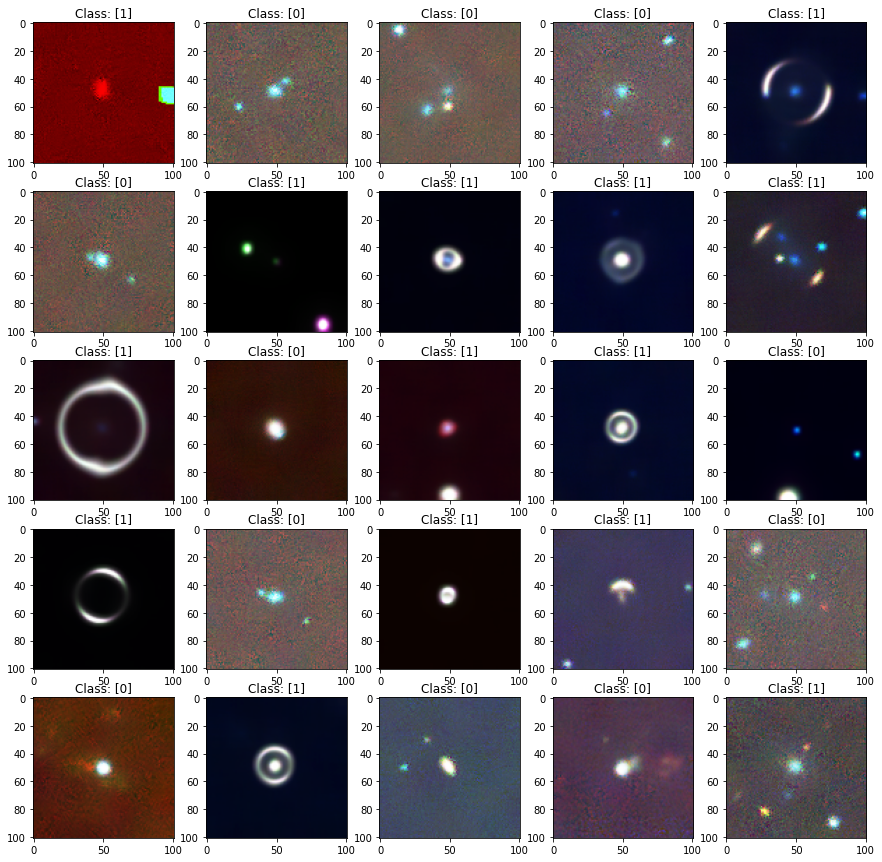

<Figure size 432x288 with 0 Axes>

In [10]:
index = save_clue(x_datas, y_data, TR, version, 1, input_shape, 5, 5, index)

<Figure size 576x432 with 0 Axes>

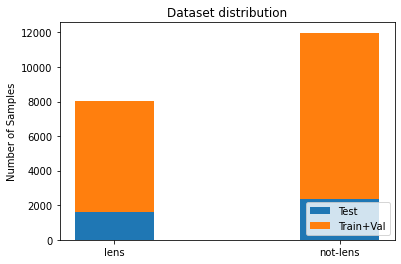

In [11]:
distrib_graph(y_data[0:TR], y_data[TR:(TR+vallim)], y_data[(TR+vallim):int(len(y_data))], classes, TR)


 ** Generating data_analysis graph...
 ** This could take some time. You may proceed.


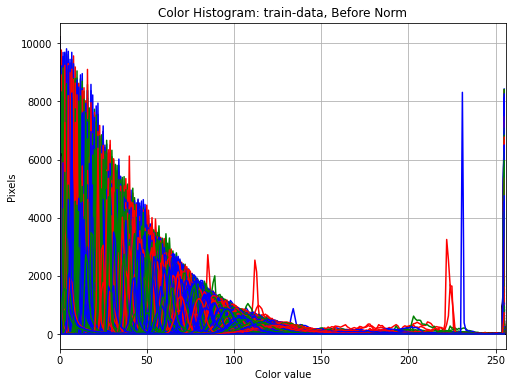

<Figure size 432x288 with 0 Axes>

In [12]:
analyze_data(x_datas, y_data, dataset_size, TR, shots, input_shape, meta_iters, version, normalize, "Before Norm", "train")

In [13]:
print(" ** Normalyze step...")
x_datas = (x_datas - np.nanmin(x_datas))/np.ptp(x_datas)

 ** Normalyze step...


In [14]:
print(" ** Resizing images to given input_shape %s x %s..." % (input_shape, input_shape))
print(" ** old_shape: ", x_datas.shape)
x_data = tf.image.resize(x_datas, [input_shape, input_shape], preserve_aspect_ratio=True)
x_data = np.array(x_data)
print(" ** new_shape: ", x_data.shape)

 ** Resizing images to given input_shape 32 x 32...
 ** old_shape:  (20000, 101, 101, 3)
 ** new_shape:  (20000, 32, 32, 3)


In [15]:
print(" ** Separating test_set used for final evaluation.")
x_test = x_data[(TR+vallim):int(len(y_data)),:,:,:]
y_test = y_data[(TR+vallim):int(len(y_data))]

 ** Separating test_set used for final evaluation.


Now it's the time to build the dataset functions calling Dataset class. This class has the function "get_mini_dataset" inside which reaps the necessary support and query sets.





 ** Building dataset functions:
 ** Train_dataset is bein imported...
 ** split: train
 ** x_data:   (12000, 32, 32, 3)
 ** y_data:   (12000, 1)


<Figure size 432x288 with 0 Axes>

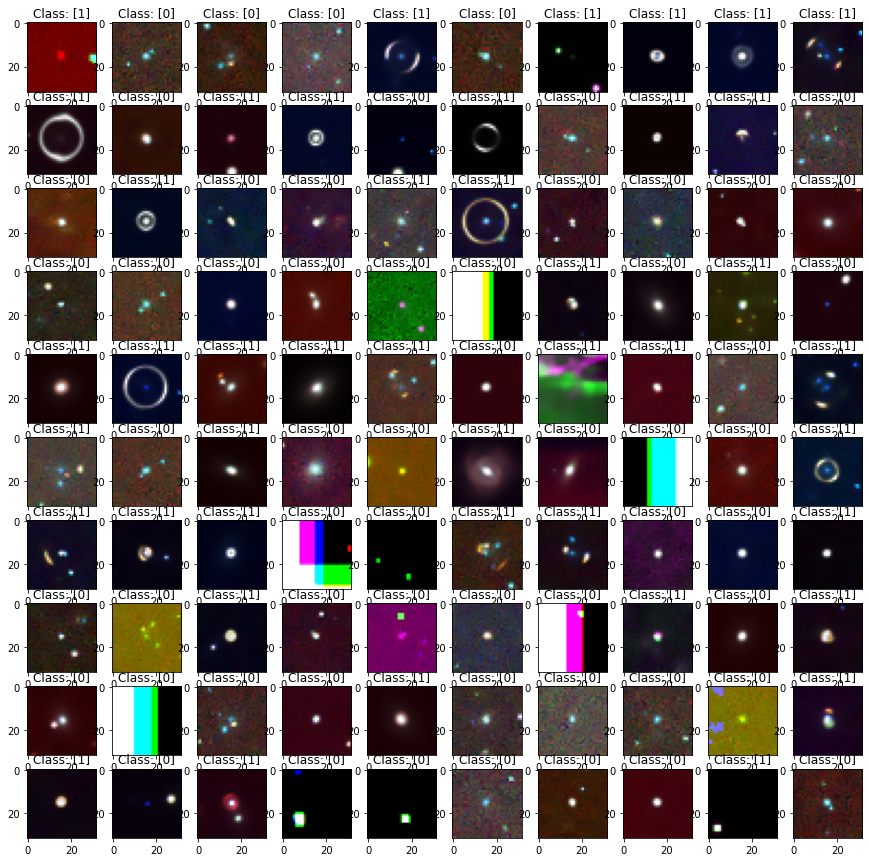

 ** train DATASET PREPARED!
 ** Test_dataset is bein imported...
 ** split: test
 ** x_data:   (4000, 32, 32, 3)
 ** y_data:   (4000, 1)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

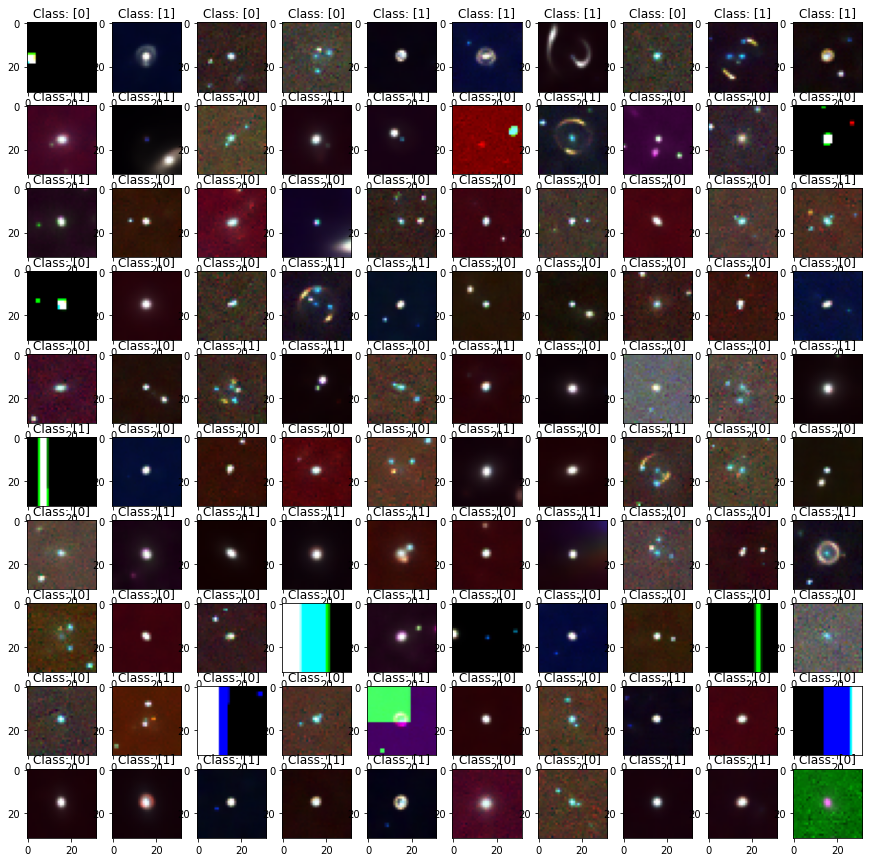

 ** test DATASET PREPARED!


<Figure size 432x288 with 0 Axes>

In [16]:
print("\n ** Building dataset functions:")
print(" ** Train_dataset is bein imported...")
train_dataset = Dataset(x_data=x_data, y_data=y_data, split="train", version=version, TR=TR, 
vallim=vallim, index=index, input_shape=input_shape, num_channels=num_channels)
print(train_dataset)
print(" ** Test_dataset is bein imported...")
test_dataset = Dataset(x_data=x_data, y_data=y_data, split="test", version=version, TR=TR, 
vallim=vallim, index=index, input_shape=input_shape, num_channels=num_channels)
print(test_dataset)

Next we can define the model according to parameters given in parameters section.

In [24]:
print(" ** Network building stage...")
img_shape = (x_data.shape[1], x_data.shape[2], x_data.shape[3])
img_input = Input(shape=img_shape)
if architecture == "ResNet50":
    model = ResNet50(include_top=True, weights=None, input_tensor=img_input, input_shape=img_shape, classes=2, pooling=None)
elif architecture == "VGG16":
    model = VGG16(include_top=False, weights=None, input_tensor=img_input, input_shape=img_shape, classes=2, pooling=None)
    x_data = preprocess_input(x_data)
elif architecture == "InceptionV3":
    model = InceptionV3(include_top=False, weights=None, input_tensor=img_input, input_shape=img_shape, classes=2, pooling=None)
elif architecture == "Basic":
    model = basic_conv_model(normalize, dropout, maxpooling, activation_layer, output_layer, input_shape, num_channels, 128, 3, "same", learning_rate, optimizer, num_classes)
elif architecture == "ResNet":
    model = ResNet_Generator(input_shape, 32, num_classes, img_input)
else:
    raise Exception(" Please make sure you have typed network-type correctly.")
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, run_eagerly=True)

 ** Network building stage...
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 32, 32, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 32, 32, 16)   64          conv2d_72[0][0]                  
__________________________________________________________________________________________________
activation_66 (Activation)      (None, 32, 32, 16)   0           batch_normalization_68[0][0]     
_________________________________________________________

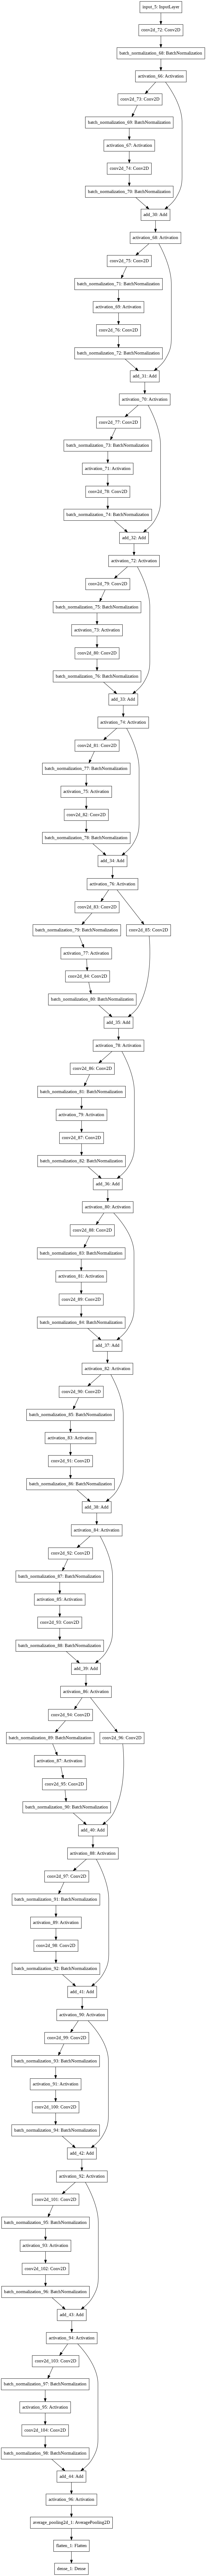

In [28]:
plot_model(model, to_file="model_REPTILE_%s_version_%s.png" % (architecture, version))

#EVERYTHING is fine, if you've reached this step.
Now, it's time to initialyze REPTILE algorithm.

In [ ]:
training, testing, tes_losses, tra_losses = ([] for i in range(4))
print("\n ** IT'S TIME TO META_TRAIN!")
train_timer = time.perf_counter()
for meta_iter in range(meta_iters):   ##FROM 0 TO 2000
    meta_step_timer = time.perf_counter()
    frac_done = meta_iter / meta_iters
    print('\n **********************************\n **** STEP: {}/{} \n ** Fraction done: {} %.'. format((meta_iter+1), meta_iters, frac_done))
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    old_vars = model.get_weights()  # Temporarily save the weights from the model.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots,
        num_classes, input_shape, num_channels)   # Get a sample from the full dataset.
    print(" -- Clue of mini_dataset: ", mini_dataset)  
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds) 
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
            )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    print("\n ** EVALUATION LOOP!")
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies, mean_loss = ([] for i in range(2))
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                    eval_batch_size, eval_iters, shots, num_classes, input_shape, num_channels, split="training"
                )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                #index = save_clue(images, labels, TR, version, 7, input_shape, 3, 3, index)
                print(images[0].shape)
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            #num_correct = sum(1 for a, b in zip(test_preds, test_labels) if a == b[0])
            mean_loss.append(log_loss(test_labels, test_preds))
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / num_classes)
        tra_losses.append(mean_loss[0])
        tes_losses.append(mean_loss[1])
        training.append(accuracies[0])
        testing.append(accuracies[1])
        print("train_acc:", training)
        print("test_acc:", testing)
        if meta_iter % 100 == 0:
            print(" ** batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1]))
        elapsed = int((time.perf_counter() - meta_step_timer))
        print(" ** step_time: %s seconds." % elapsed)
print("\n\n\n ** Training finished in %s minutes." % (int((time.perf_counter() - train_timer))))

#TRAINING IS COMPLETE!
Now it's time to evaluate our model.

In [ ]:
train_y = conv_window(training)
test_y = conv_window(testing)
tra_loss = conv_window(tra_losses)
tes_loss = conv_window(tes_losses)

acc_graph(test_y, train_y, TR, shots, input_shape, meta_iters, version, normalize)

In [ ]:
loss_graph(tra_loss, tes_loss, TR, shots, input_shape, meta_iters, version, normalize)

In [ ]:
tpr, fpr, auc, auc2, thres = ROCCurveCalculate(y_test, x_test, model)
f1_score, f001_score = FScoreCalc(y_test, x_test, model)
roc_curve_graph(fpr, tpr, auc, TR, shots, input_shape, meta_iters, version, normalize, f1_score, f001_score)